## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-12):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-12):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
models = [build_mlp_l1,build_mlp_l2]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for build_mlp in models:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print('Experiment with Regulizer = %s' % str(build_mlp))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-%s" % str(build_mlp)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}





Experiment with Regulizer = <function build_mlp_l1 at 0x0000026637428708>


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________

Instructions for updating:
Use tf.w

50000/50000 [==============================] - 2s 41us/step - loss: 0.9843 - acc: 0.6546 - val_loss: 1.3476 - val_acc: 0.5312
Epoch 42/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.9717 - acc: 0.6599 - val_loss: 1.3699 - val_acc: 0.5267
Epoch 43/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.9609 - acc: 0.6633 - val_loss: 1.3714 - val_acc: 0.5262
Epoch 44/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.9491 - acc: 0.6689 - val_loss: 1.4434 - val_acc: 0.5080
Epoch 45/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.9371 - acc: 0.6732 - val_loss: 1.4473 - val_acc: 0.5160
Epoch 46/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.9242 - acc: 0.6744 - val_loss: 1.4191 - val_acc: 0.5199
Epoch 47/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.9105 - acc: 0.6801 - val_loss: 1.5125 - val_acc: 0.4950
Epoch 48/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 43us/step - loss: 0.9750 - acc: 0.6581 - val_loss: 1.3334 - val_acc: 0.5344
Epoch 43/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.9568 - acc: 0.6667 - val_loss: 1.3282 - val_acc: 0.5349
Epoch 44/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.9453 - acc: 0.6700 - val_loss: 1.3637 - val_acc: 0.5322
Epoch 45/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.9293 - acc: 0.6749 - val_loss: 1.4315 - val_acc: 0.5116
Epoch 46/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.9218 - acc: 0.6757 - val_loss: 1.4184 - val_acc: 0.5189
Epoch 47/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.9113 - acc: 0.6822 - val_loss: 1.3643 - val_acc: 0.5317
Epoch 48/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.8968 - acc: 0.6858 - val_loss: 1.3371 - val_acc: 0.5409
Epoch 49/50
50000/50000 [=====================

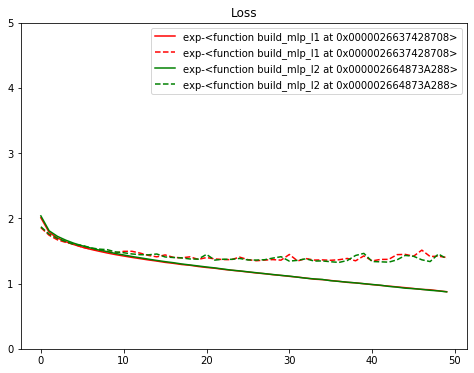

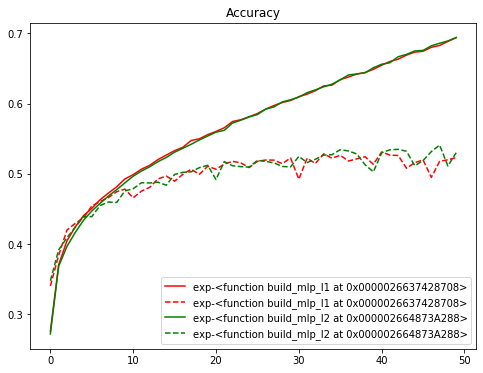

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()